In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [2]:
SEED = 1
sns.set(rc={'figure.figsize': (9, 6)})
sns.set_style('white')

In [3]:
# Load the data

df = pd.read_csv('data.csv')

In [4]:
df.shape

(7043, 21)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### Good News: There's no missing data

# EDA

In [8]:
# Find the ratio of churned customers

print(df['Churn'].value_counts(normalize=False))
print('\n')
print(df['Churn'].value_counts(normalize=True))

No     5174
Yes    1869
Name: Churn, dtype: int64


No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


### The distribution is imbalanced as ratio of churned customers is only 0.26

In [9]:
# Replace the text values in Churn column with boolean values of 0 and 1

df['Churn'].replace({'No': 0, 'Yes': 1}, inplace=True)

In [10]:
target_variable = 'Churn'

In [11]:
def plot_categorical_column(column_name):
    """
    A generic function to plot the distribution of a categorical column, and
    the ratio of Churn in each of the values of that column.
    """
    f, (ax1, ax2) = plt.subplots(2, figsize=(9, 12))
    sns.countplot(x=column_name, data=df, ax=ax1)
    sns.pointplot(x=column_name, y=target_variable, data=df, ax=ax2)
    ax2.set_ylim(0, 0.5)

In [12]:
def plot_continuous_column(column_name):
    """
    A generic function to plot the distribution of a continuous column, and
    boxplot of that column for each value of Churn
    """
    f, (ax1, ax2) = plt.subplots(2, figsize=(9, 12))
    sns.distplot(df[column_name], ax=ax1)
    sns.boxplot(x='Churn', y=column_name, data=df, ax=ax2)

## Visualize gender column

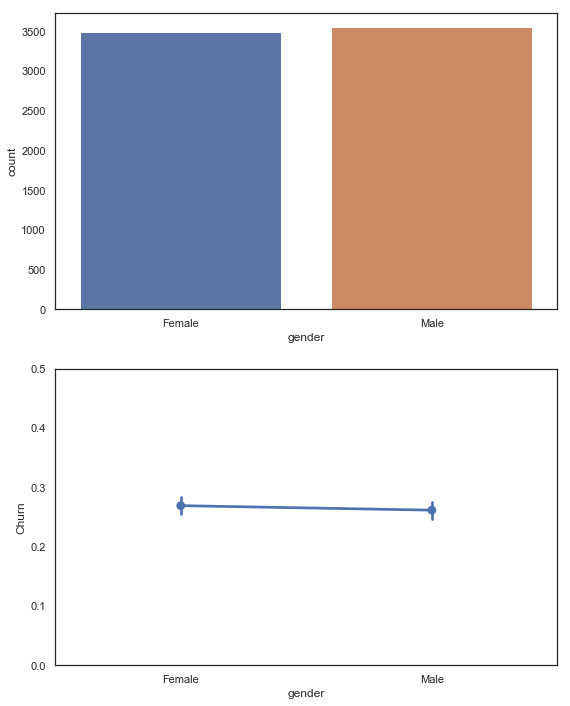

In [13]:
plot_categorical_column('gender')

### Observation: The ratio of Female and Male is quite comparable, the churn probabilities are also almost the same in both the classes

## Visualize SeniorCitizen column

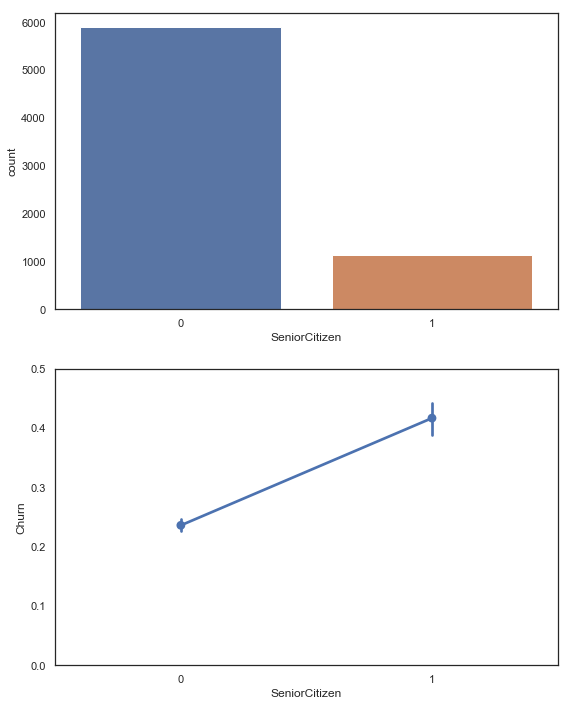

In [14]:
plot_categorical_column('SeniorCitizen')

### Observation: The churn probability of senior citizens is quite high with the prob being more than 0.4

## Visualize Partner column

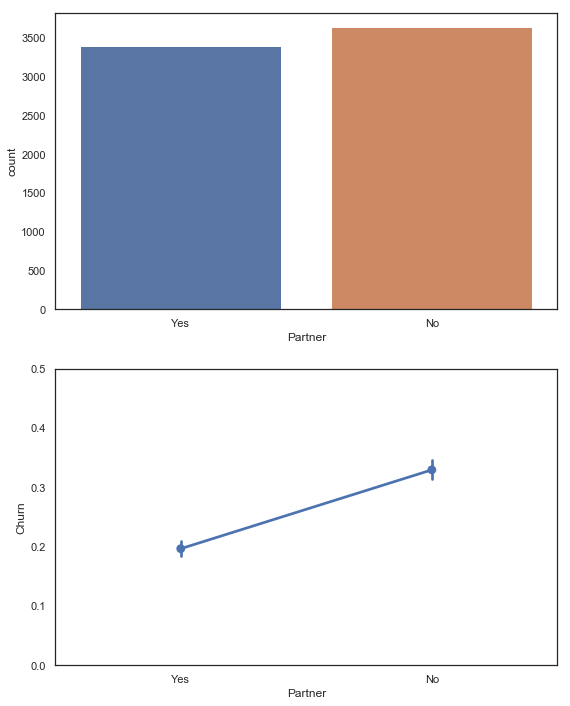

In [15]:
plot_categorical_column('Partner')

### Observation: People without partners are more likely to churn

## Visualize Dependents column

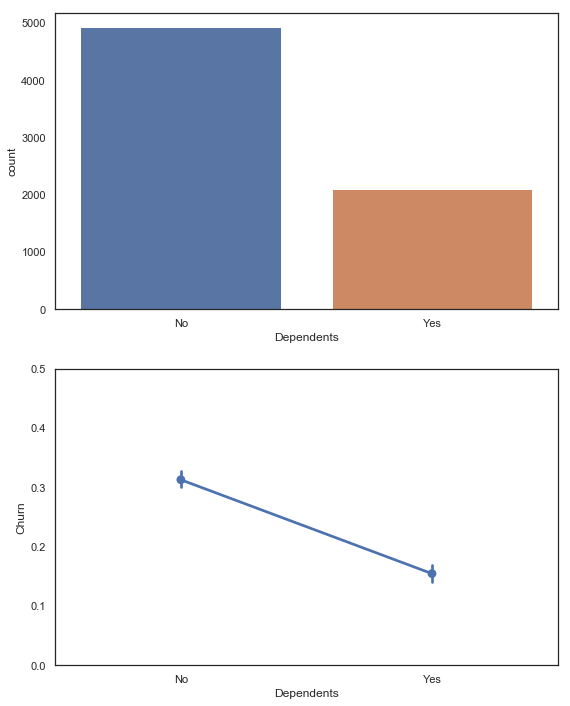

In [16]:
plot_categorical_column('Dependents')

### Observation: Similar to partners, people without dependents are more likely to churn

## Visualize Tenure column

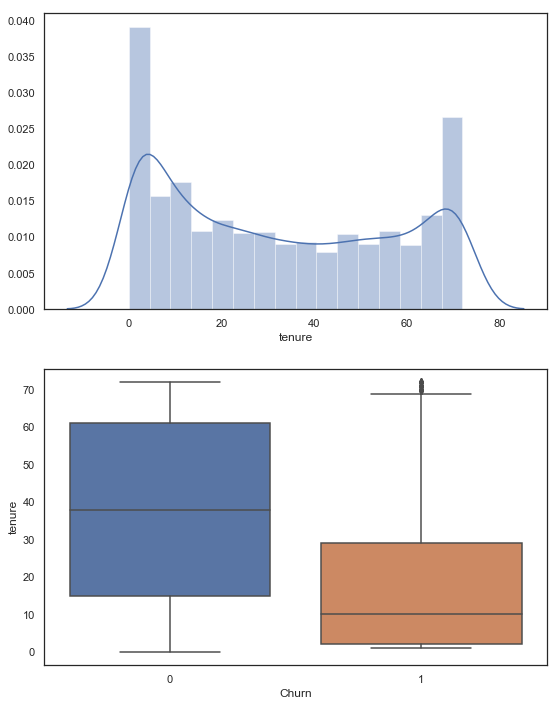

In [17]:
plot_continuous_column('tenure')

### Observation: As expected, people who have less tenure are more likely to churn. When people have been associated for long, they tend to stick around.

## Visualize PhoneService column

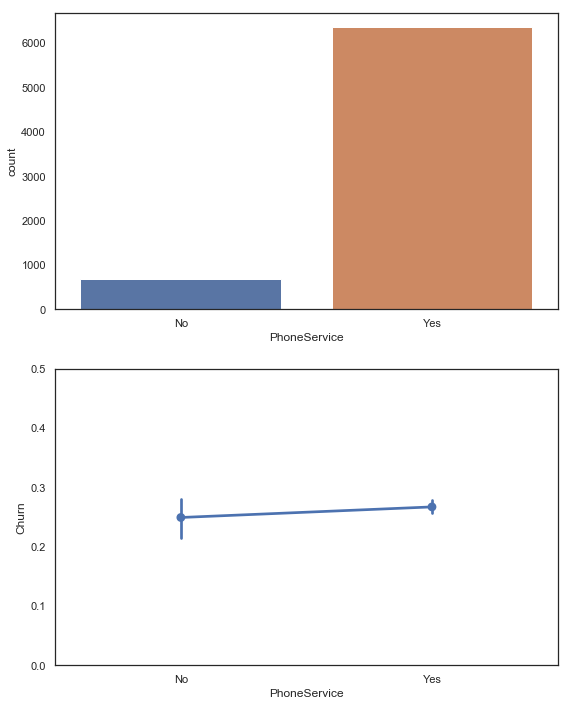

In [18]:
plot_categorical_column('PhoneService')

### Observation: No real impact of PhoneService as most people are using it.

## Visualize MultipleLines column

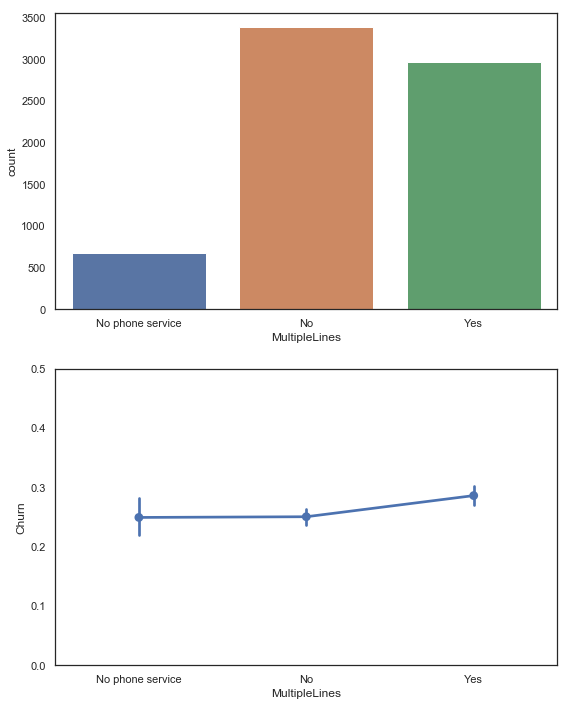

In [19]:
plot_categorical_column('MultipleLines')

### Observation: Multiple Lines is increasing the churn, although the effect is small

## Visualize InternetService column

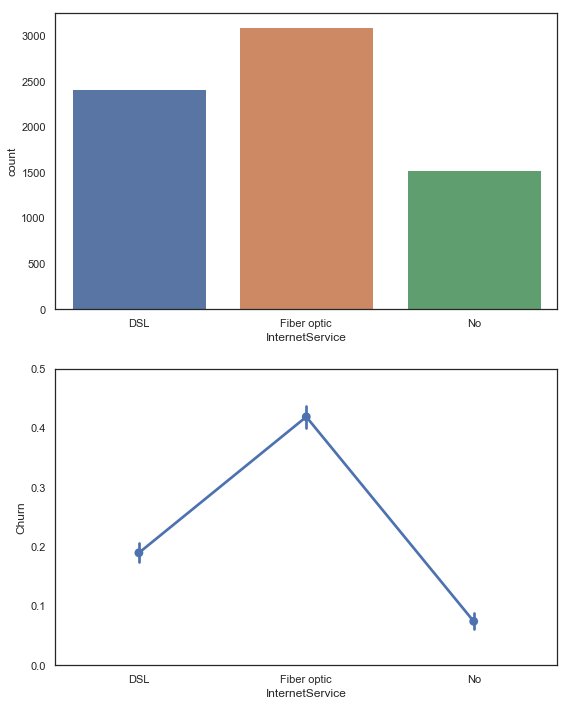

In [20]:
plot_categorical_column('InternetService')

### Observation: Internet Service is looking like a major reason for churn, as we can see that the churn rate for those people who don't use internet services is real low ~ 0.07, and it becomes more than 0.4 for people who are using Fiber optic.
### The company should really focus on improving its Fiber optic services.

## Visualize OnlineSecurity column

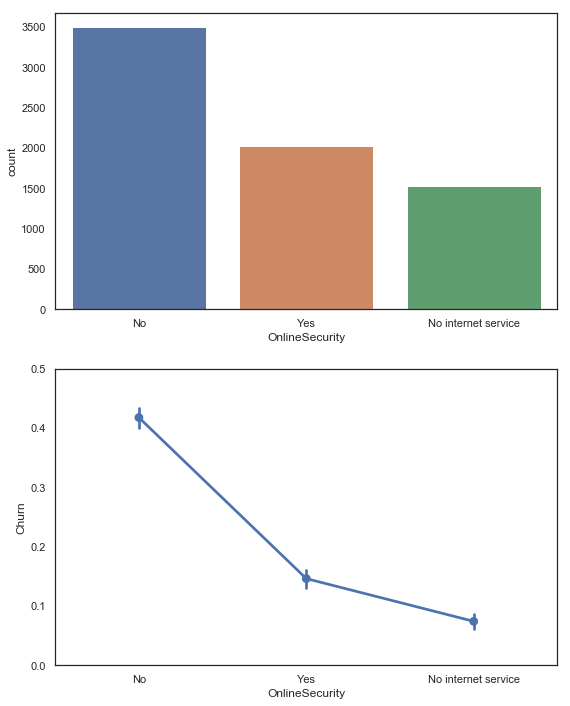

In [21]:
plot_categorical_column('OnlineSecurity')

### Observation: People who take the Online security service are less likely to churn. Company should promote this service, maybe give a discount also if need be, because it greatly improves the churn rate.

## Visualize OnlineBackup column

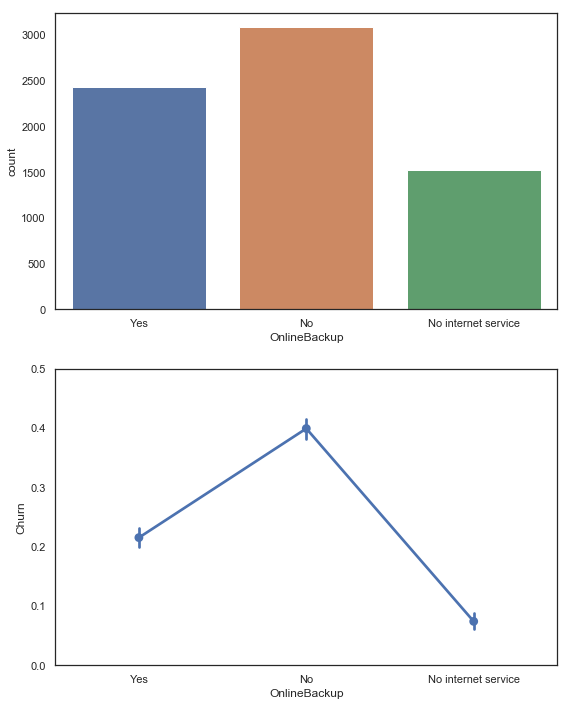

In [22]:
plot_categorical_column('OnlineBackup')

### Observation: Similar to the Online security service, Online backup service should also be promoted as this also improves in customer retention.

## Visualize DeviceProtection column

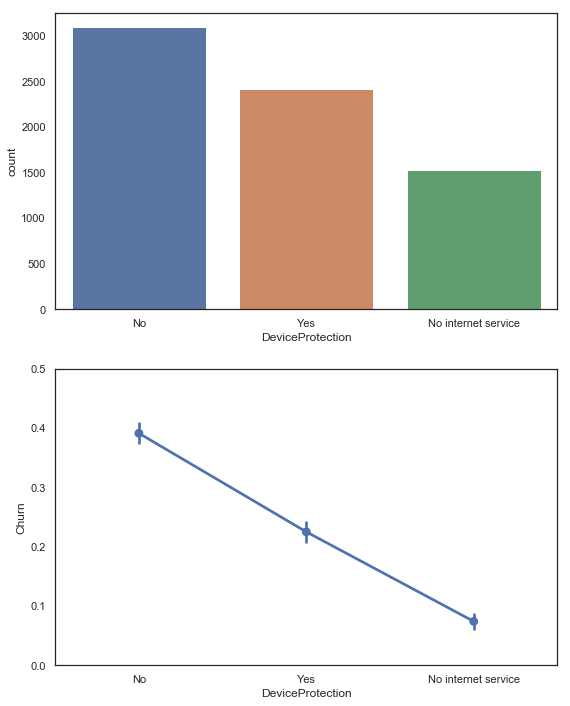

In [23]:
plot_categorical_column('DeviceProtection')

### Observation: DeviceProtection service helps in reducing the churn rate.

## Visualize TechSupport column

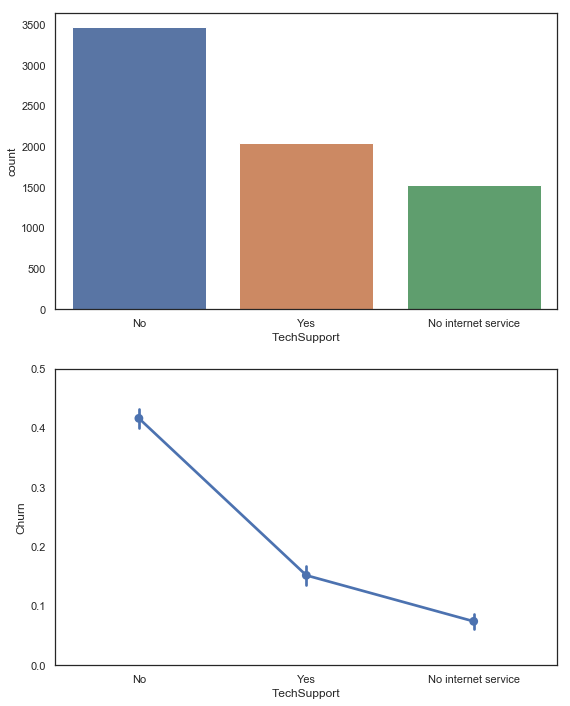

In [24]:
plot_categorical_column('TechSupport')

### Observation: TechSupport service also helps in reducing the churn rate.

## Visualize StreamingTV column

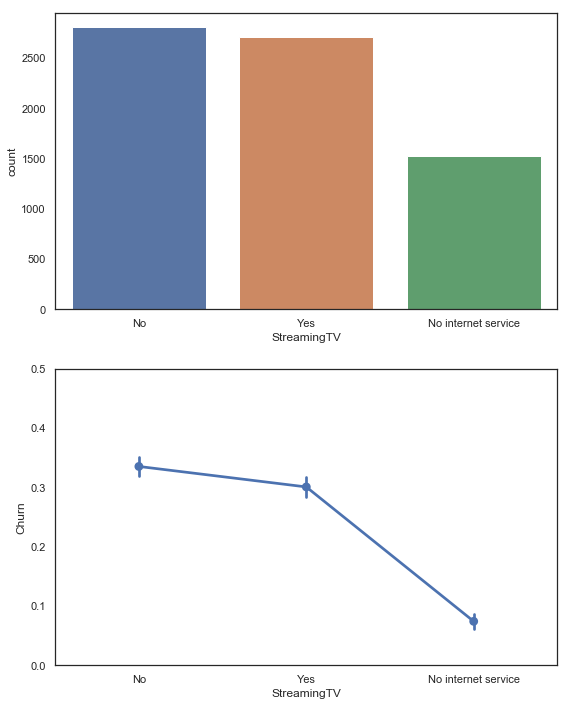

In [25]:
plot_categorical_column('StreamingTV')

### Observation: Not much impact of StreamingTV service on churn rate.

## Visualize StreamingMovies column

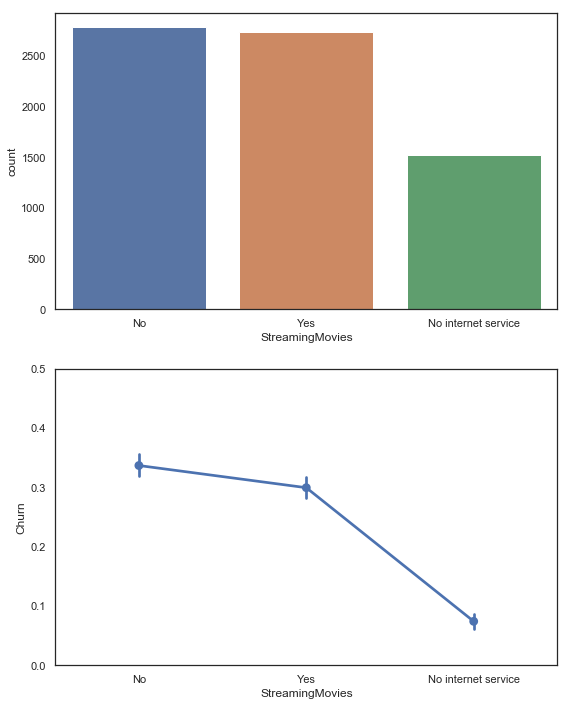

In [26]:
plot_categorical_column('StreamingMovies')

### Observation: Not much impact of StreamingMovies service on churn rate.

## Visualize Contract column

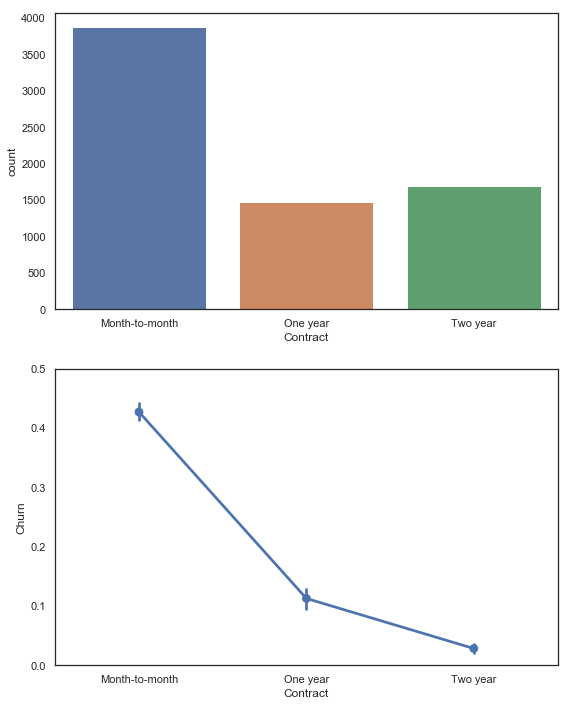

In [27]:
plot_categorical_column('Contract')

### Observation: As expected, people who opt for long contracts are less likely to churn as evident from the "Two year" contract, highest churn rate is from people who opt for monthly contract.
### If the company can manage to convert the monthly people to take the one-year/two-year contract, the churn rate can vastly come down.

## Visualize PaperlessBilling column

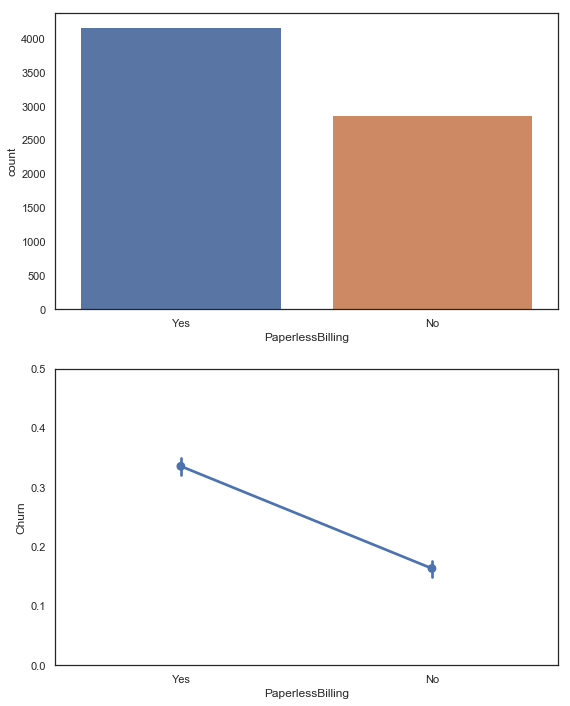

In [28]:
plot_categorical_column('PaperlessBilling')

### Observation: Seems that people who opt for paperless bills are less likely to churn. Maybe because people generally don't spend too much time on paperless bills, they do more on hard copies. This could be one theory, could be any other reason also.

## Visualize PaymentMethod column

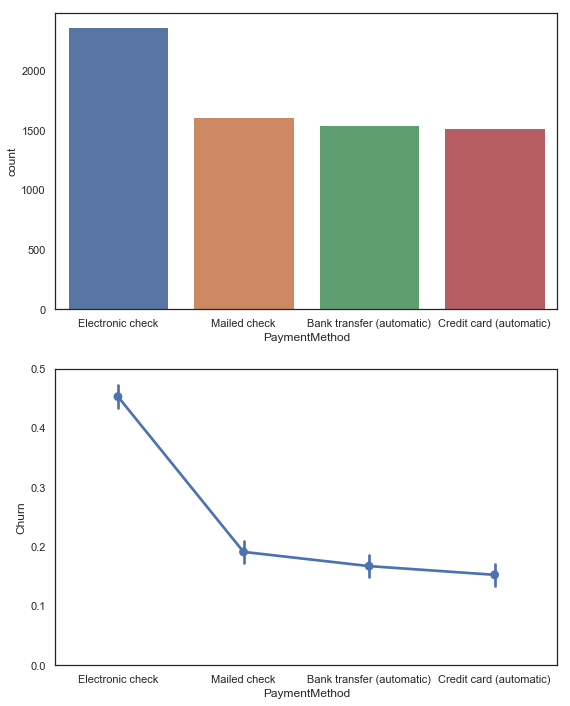

In [29]:
plot_categorical_column('PaymentMethod')

### Observation: Churn rate is highest for Electronic check payment method. As expected, automatic payment methods have low churn rate as people care less when the amount is debited automatically.

## Visualize MonthlyCharges column

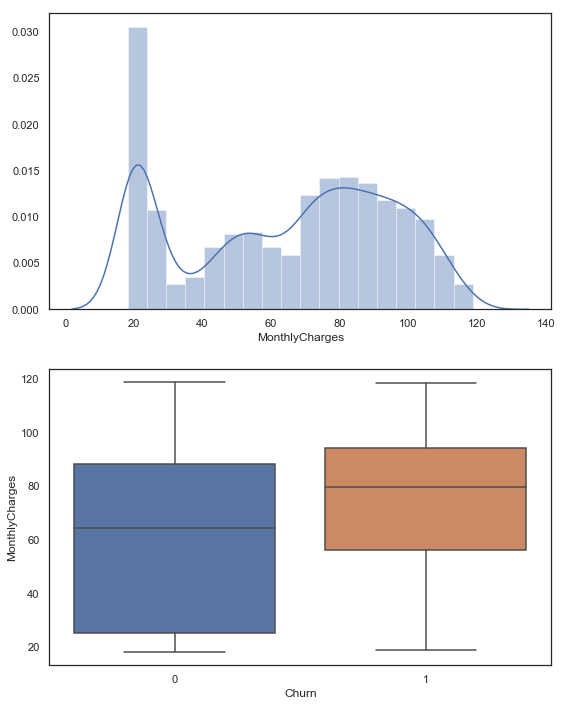

In [30]:
plot_continuous_column('MonthlyCharges')

### Observation: People who have comparatively high monthly charges are more likely to churn

# Modeling

### Replace binary text values with numbers

In [31]:
binary_columns_replace_dict = {
    'gender': {
        'Female': 0,
        'Male': 1
    },
    'Partner': {
        'No': 0,
        'Yes': 1
    },
    'Dependents': {
        'No': 0,
        'Yes': 1
    },
    'PhoneService': {
        'No': 0,
        'Yes': 1
    },
    'MultipleLines': {
        'No phone service': 0,
        'No': 0,
        'Yes': 1
    },
    'OnlineSecurity': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'OnlineBackup': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'DeviceProtection': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'TechSupport': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'StreamingTV': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'StreamingMovies': {
        'No internet service': 0,
        'No': 0,
        'Yes': 1
    },
    'PaperlessBilling': {
        'No': 0,
        'Yes': 1
    }
}

for binary_col in binary_columns_replace_dict:
    df[binary_col].replace(binary_columns_replace_dict[binary_col], inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null int64
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
tenure              7043 non-null int64
PhoneService        7043 non-null int64
MultipleLines       7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
Contract            7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null int64
dtypes: float64(1), int64(15), object(5)
memor

### Create dummy variables

In [33]:
categorical_columns = ['InternetService', 'Contract', 'PaymentMethod']

for categorical_column in categorical_columns:
    dummy_df = pd.get_dummies(df[categorical_column], prefix=categorical_column, drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)

### Create new features

In [34]:
# Create a feature for the number of internet services used

df['internet_services_count'] = df['OnlineSecurity'] + df['OnlineBackup'] + df['DeviceProtection'] \
                                + df['TechSupport'] + df['StreamingTV'] + df['StreamingMovies']

In [35]:
# Create a feature for checking if the payment is automatic or not

df['is_payment_automatic'] = df['PaymentMethod'].isin(['Bank transfer (automatic)', 'Credit card (automatic)'])

### Scale the data

In [36]:
target_variable = 'Churn'

In [37]:
features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'PaperlessBilling', 'MonthlyCharges', 'internet_services_count', 'is_payment_automatic'
]

for col in df.columns:
    if not col in features and col.startswith(('InternetService_', 'Contract_')):
        features.append(col)

In [38]:
features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'MonthlyCharges',
 'internet_services_count',
 'is_payment_automatic',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_One year',
 'Contract_Two year']

In [39]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[features]))
scaled_df.columns = features
scaled_df[target_variable] = df[target_variable]

### Try running different models

In [40]:
def evaluate_models(df, features):
    """
    Evaluate different models on the passed dataframe using the given features.
    """
    
    # Create testing and training data
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target_variable], test_size=0.2, random_state=SEED
    )

    results = {} # to store the results of the models
    models = [
        ('lr', LogisticRegression(random_state=SEED)),
        ('lda', LinearDiscriminantAnalysis()),
        ('svm', SVC(random_state=SEED)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('nb', GaussianNB()),
        ('dt', DecisionTreeClassifier(random_state=SEED)),
        ('rf', RandomForestClassifier(random_state=SEED, n_estimators=100)),
        ('et', ExtraTreesClassifier(random_state=SEED, n_estimators=100)),
        ('gb', GradientBoostingClassifier(random_state=SEED, n_estimators=100)),
        ('ada', AdaBoostClassifier(random_state=SEED)),
        ('xgb', xgb.XGBClassifier(random_state=SEED))
        
    ]

    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        results[model_name] = (model, accuracy, f1, cm)
        
    sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)
    for model_name, (model, accuracy, f1, cm) in sorted_results:
        print(model_name, accuracy, f1)
        
    return results

In [44]:
results = evaluate_models(scaled_df, features)

xgb 0.8176011355571328 0.6100151745068285
gb 0.8168914123491838 0.6160714285714285
ada 0.8126330731014905 0.6059701492537314
lr 0.8062455642299503 0.5955555555555555
svm 0.8055358410220014 0.5718749999999999
lda 0.8034066713981547 0.5944363103953149
rf 0.7885024840312278 0.5457317073170732
knn 0.765791341376863 0.5365168539325843
et 0.7643718949609652 0.5103244837758113
nb 0.7544357700496807 0.6247288503253796
dt 0.7331440738112136 0.48773841961852865


### XGBoost is giving the highest accuracy of 0.8176

### Lets apply cross validation to it

In [45]:
model = xgb.XGBClassifier(random_state=SEED)
cross_val_scores = cross_val_score(model, scaled_df[features], scaled_df[target_variable], cv=5)
print(cross_val_scores.mean())

0.8054805562575444


### Cross validation accuracy: 0.8054